
# Etapa 05 – Interpretabilidade dos Modelos

## 🎯 Objetivo

Compreender os principais fatores que influenciam o risco de desligamento (Attrition) com base nos modelos treinados.

---

## 📊 1. Importância Global das Variáveis

Apresenta as variáveis mais relevantes para o modelo. Utilizamos:

- Feature Importance (para Random Forest e LightGBM)
- Coeficientes padronizados (para Regressão Logística)

```python
# Exemplo para LightGBM
import matplotlib.pyplot as plt
importances = model_lgbm.feature_importances_
features = X_train.columns
indices = importances.argsort()[::-1][:20]

plt.figure(figsize=(10, 6))
plt.barh(range(20), importances[indices][::-1])
plt.yticks(range(20), features[indices][::-1])
plt.xlabel("Importância")
plt.title("Top 20 Features - LightGBM")
plt.show()
```

---

## 🔍 2. Interpretação com SHAP

Usamos a biblioteca SHAP para entender **como cada feature afeta a previsão do modelo** em nível individual e global.

```python
import shap

explainer = shap.Explainer(model_lgbm, X_train)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

# Exemplo local (explicação individual de uma predição)
shap.plots.waterfall(shap_values[10])
```

---

## 🧠 3. Insights

```text
- A variável "SatisfactionScore" aparece entre as mais importantes, sugerindo que a satisfação no trabalho é um forte indicador de risco.
- "YearsSinceLastPromotion" e "DistanceFromHome" também tiveram impacto considerável.
- A combinação de múltiplas variáveis reforça a complexidade do fenômeno de desligamento.
```

              precision    recall  f1-score   support

           0       0.79      1.00      0.88     23810
           1       0.00      0.00      0.00      6190

    accuracy                           0.79     30000
   macro avg       0.40      0.50      0.44     30000
weighted avg       0.63      0.79      0.70     30000

[[23810     0]
 [ 6190     0]]


/Users/drico/Desktop/Mack/hr-analytics/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/drico/Desktop/Mack/hr-analytics/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/drico/Desktop/Mack/hr-analytics/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/drico/Desktop/Mack/hr-analytics/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pr

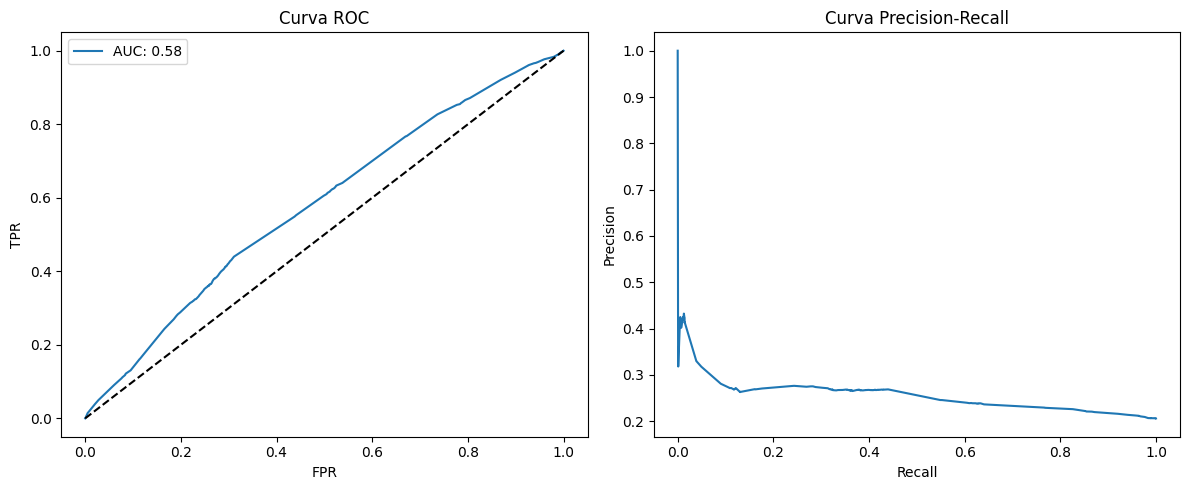

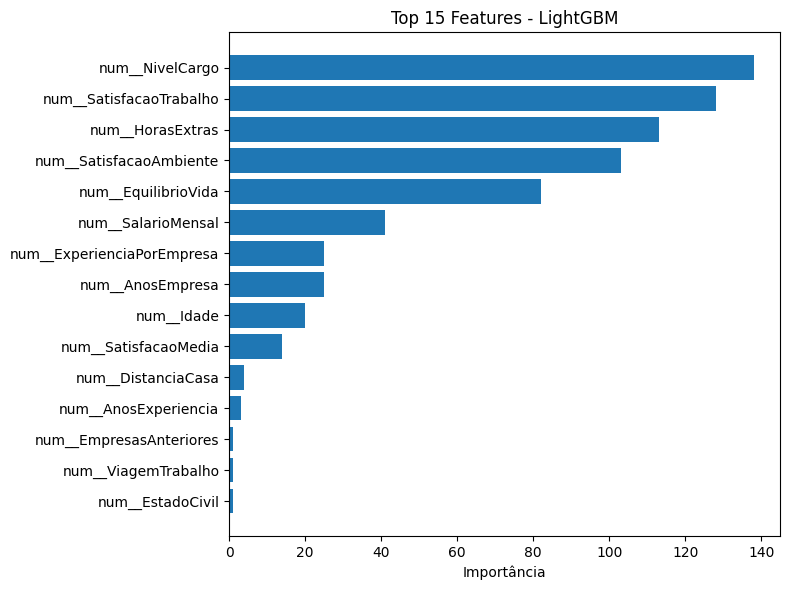

/var/folders/k8/d8rmnjz55k32kpt5zpy0w9r80000gn/T/ipykernel_82993/1869613647.py:79: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_transf, feature_names=feature_names)


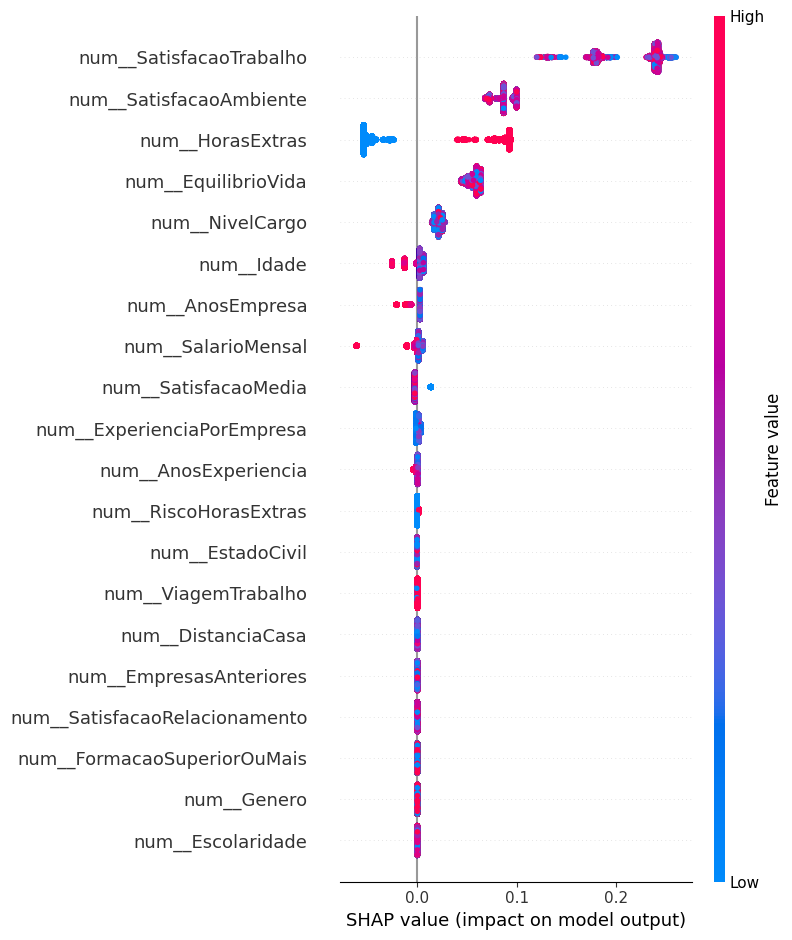

In [7]:
# Script de Aplicação e Interpretabilidade do Modelo Final

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import joblib
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
import sys
import os
sys.path.append(os.path.abspath("../"))
from scripts.func import preparar_dados_rh

# Carregar dados
df_encoded, X_train, X_test, y_train, y_test = preparar_dados_rh(qtd_amostras=100_000, semente=42)

# Carregar modelo e preprocessador

try:
    root_dir = os.path.abspath(os.path.join(os.path.dirname(__file__), '..'))
except NameError:
    root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

models_dir = os.path.join(root_dir, 'models')

modelo = joblib.load(os.path.join(models_dir, 'lightgbm_model.pkl'))
preprocessador = joblib.load(os.path.join(models_dir, 'preprocessor.pkl'))

# Transformar dados
X_test_transf = preprocessador.transform(X_test)

# Previsões
y_pred = modelo.predict(X_test_transf)
y_proba = modelo.predict_proba(X_test_transf)[:, 1]

# Relatório
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Curvas ROC e PR
fpr, tpr, _ = roc_curve(y_test, y_proba)
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC: {auc(fpr, tpr):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Curva ROC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision)
plt.title("Curva Precision-Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.tight_layout()
plt.show()

# Importância das features
importances = modelo.feature_importances_
feature_names = preprocessador.get_feature_names_out()
top_idx = np.argsort(importances)[-15:]
plt.figure(figsize=(8, 6))
plt.barh(range(len(top_idx)), importances[top_idx], tick_label=feature_names[top_idx])
plt.title("Top 15 Features - LightGBM")
plt.xlabel("Importância")
plt.tight_layout()
plt.show()

# Interpretabilidade com SHAP
explainer = shap.Explainer(modelo)
shap_values = explainer(X_test_transf)

shap.summary_plot(shap_values, X_test_transf, feature_names=feature_names)

# Função para produção
def prever_attrition(novos_dados: pd.DataFrame) -> pd.Series:
    '''
    Funcao final para producao.
    Recebe DataFrame com os dados e retorna a probabilidade de desligamento.
    '''
    dados_transformados = preprocessador.transform(novos_dados)
    probas = modelo.predict_proba(dados_transformados)[:, 1]
    return pd.Series(probas, index=novos_dados.index, name='probabilidade_desligamento')
